# Сборный проект 2. HR-аналитика

## Описание проекта

Перейдём к задаче. HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников. В этом HR-аналитикам пригодится машинное обучение, с помощью которого получится быстрее и точнее отвечать на вопросы бизнеса. Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён. Собирать данные такими опросниками не так легко: компания большая, и всех сотрудников надо сначала оповестить об опросе, а затем проследить, что все его прошли.
У вас будет несколько задач. Первая — построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика.
Почему бизнесу это важно: удовлетворённость работой напрямую влияет на отток сотрудников. А предсказание оттока — одна из важнейших задач HR-аналитиков. Внезапные увольнения несут в себе риски для компании, особенно если уходит важный сотрудник. Ваша вторая задача — построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

**Ход работы для задачи 1 (предсказание уровня удовлетворенности сотрудника):**

1. Загрузка данных
2. Предобработка данных
3. Исследовательский анализ данных
4. Подготовка данных
5. Обучение моделей
6. Оформление выводов

**Ход работы для задачи 2:**

7. Загрузка данных
8. Предобработка данных
9. Исследовательский анализ данных
10. Добавление нового входного признака
11. Подготовка данных
12. Обучение моделей
13. Оформление выводов

_

14. Общий вывод

**Описание признаков:**

* id — уникальный идентификатор сотрудника;
* dept — отдел, в котором работает сотрудник;
* level — уровень занимаемой должности;
* workload — уровень загруженности сотрудника;
* employment_years — длительность работы в компании (в годах);
* last_year_promo — показывает, было ли повышение за последний год;
* last_year_violations — показывает, нарушал ли сотрудник трудовой договор за последний год;
* supervisor_evaluation — оценка качества работы сотрудника, которую дал руководитель;
* salary — ежемесячная зарплата сотрудника;
* job_satisfaction_rate — уровень удовлетворённости сотрудника работой в компании, целевой признак.

In [1]:
!pip install matplotlib -q
!pip install shap -q
!pip install phik -q
!pip install -U scikit-learn -q

In [2]:
import shap
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt

from phik.report import plot_correlation_matrix
from phik import report
from phik import phik_matrix
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.impute import SimpleImputer 
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [3]:
from sklearn.preprocessing import LabelEncoder

In [4]:
RANDOM_STATE = 42

Так как предстоит обработать много df удобней будет использзовать готовые функции, чтобы избежать дублирование кода

In [5]:
# Функция для вывода основной информации о df:
# вывод 7 рандомных строк, явных дубликатов и пропусков

def df_info(data):
    display(data.sample(7))
    display(data.info())
    print('------------------------------------------')
    print('Количество явных дубликатов: ', data.duplicated().sum())
    print('------------------------------------------')
    print('Количество пропусков:')
    print(data.isna().sum())

In [6]:
# Функция для проверки на неявные дубликаты
# Она будет выводить уникальные значения столбца

def dublicates(data):
    for i in data.columns:
        if data[i].dtype == 'object':
            print(i, data[i].unique())

In [7]:
# Функция подсчета процентного соотношения пропущенных значений в df

def missing(data):
    result = data.isna().sum().to_frame()
    result = result.rename(columns = {0: 'missing_values'})
    result['%'] = (result['missing_values'] / data.shape[0]).round(2)*100
    return result.sort_values(by = 'missing_values', ascending = False)

In [8]:
# Функция построения гистограмм и диаграмм размаха для количественных данных

def histplot_boxplot(data, column, xlabel, title):
    fig, axs = plt.subplots(nrows= 1, 
                            ncols= 2, 
                            figsize = (16,8))
    sn.histplot(data = data, 
                x = column, 
                ax=axs[0], 
                bins = 40, kde=True)
    axs[0].set_xlabel(xlabel)
    axs[0].set_ylabel('Количество')
    axs[0].set_title('Гистограмма')
    sn.boxplot(data = data,
               x = column, 
               ax=axs[1])
    axs[1].set_xlabel(xlabel)
    axs[1].set_title('Диаграмма размаха')
    fig.suptitle(title)
    plt.show()

In [9]:
# Функция построения круговой диаграммы для категориальных признаков

def pie(data, column, title):
    palette_color = sn.color_palette('bright')
    data[column].value_counts().plot(y = 'count', 
                                              kind = 'pie', 
                                              autopct='%1.0f%%', 
                                              title = title, 
                                              colors = palette_color, 
                                              figsize = (16, 4))
    plt.show()

In [10]:
def matrix_cor(data, title):

    # создаём список с наименованиями непрерывных признаков
    interval_cols = ['salary', 'job_satisfaction_rate']

    # Считаем корреляции на выборке
    phik_overview = phik_matrix(data, interval_cols=interval_cols)

    # Визуализируем
    plot_correlation_matrix(
        phik_overview.values,
        x_labels=phik_overview.columns,
        y_labels=phik_overview.index,
        vmin=0, vmax=1, color_map='Greens',
        title=title,
        fontsize_factor=1.8,
        figsize=(20, 15)
    ) 

In [11]:
# Метрика Smape - функция для собственной метрики

def smape_score(y_true, y_pred):
    return 100/len(y_true) * np.sum(np.abs(y_true-y_pred)/((np.abs(y_true) + np.abs(y_pred))/2))

In [12]:
# Функция для построения круговой диаграммы по тренировочной выборке для уволившихся сотрудников

def pie_2(column_2, title):
    palette_color = sn.color_palette('bright') 
    train_2.loc[train_2['quit'] == 'yes', column_2].value_counts().plot(y = 'count', 
                                                                       kind = 'pie', 
                                                                       autopct='%1.0f%%', 
                                                                       title = title, 
                                                                       colors = palette_color, figsize = (14, 6))
    plt.show()

# Задача 1

## 1. Загрузка данных

In [13]:
train = pd.read_csv('/datasets/train_job_satisfaction_rate.csv')
X_test = pd.read_csv('/datasets/test_features.csv')
y_test = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv')

In [14]:
df_info(train)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
2259,248494,sales,sinior,medium,7,no,yes,3,44400,0.24
1377,956391,technology,junior,low,1,no,no,2,14400,0.24
2110,335499,sales,junior,medium,1,no,no,4,21600,0.42
3597,464318,marketing,middle,low,5,no,no,4,31200,0.59
832,173668,technology,junior,low,1,no,no,4,24000,0.72
2111,496187,hr,junior,medium,2,no,no,4,26400,0.81
837,596342,sales,middle,low,4,no,no,4,28800,0.67


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


None

------------------------------------------
Количество явных дубликатов:  0
------------------------------------------
Количество пропусков:
id                       0
dept                     6
level                    4
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64


In [15]:
df_info(X_test)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
656,816835,purchasing,junior,medium,4,no,no,5,22800
401,748819,purchasing,junior,medium,3,no,no,2,21600
1818,841095,technology,middle,medium,7,no,no,4,40800
814,420616,technology,junior,low,1,no,yes,3,19200
616,625386,sales,middle,medium,6,yes,no,5,34800
18,335909,hr,junior,low,1,no,no,1,12000
1571,475905,sales,junior,low,1,no,no,5,19200


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


None

------------------------------------------
Количество явных дубликатов:  0
------------------------------------------
Количество пропусков:
id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64


In [16]:
df_info(y_test)

,id,job_satisfaction_rate
403,965276,0.67
10,436938,0.91
922,477585,0.36
1058,834940,0.46
1538,733977,0.66
1577,168605,0.38
157,735138,0.84


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


None

------------------------------------------
Количество явных дубликатов:  0
------------------------------------------
Количество пропусков:
id                       0
job_satisfaction_rate    0
dtype: int64


**Промежуточный вывод:**

* Все названия столбцов в df записаны в "змеином_регистре" - их можно не корректировать;
* Типы данных заданы логично;
* Явные дубликаты не выявлены;
* Пропуски есть, далее обработаем их.

## 2. Предобработка данных

Проверим датасеты на наличие неявных дубликатов

In [17]:
dublicates(train)

dept ['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]
level ['junior' 'middle' 'sinior' nan]
workload ['medium' 'high' 'low']
last_year_promo ['no' 'yes']
last_year_violations ['no' 'yes']


In [18]:
dublicates(X_test)

dept ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
level ['junior' 'middle' 'sinior' nan]
workload ['medium' 'low' 'high' ' ']
last_year_promo ['no' 'yes']
last_year_violations ['no' 'yes']


Исправим ошибку в слове "sinior"

In [19]:
train.loc[train['level'] == 'sinior', 'level'] = 'senior'
X_test.loc[X_test['level'] == 'sinior', 'level'] = 'senior'

In [20]:
display(X_test.loc[X_test['dept'] == ' '].T)
display(X_test.loc[X_test['workload'] == ' '].T)

,1699
id,822186
dept,
level,middle
workload,medium
employment_years,3
last_year_promo,no
last_year_violations,no
supervisor_evaluation,4
salary,38400


,15
id,590867
dept,marketing
level,junior
workload,
employment_years,4
last_year_promo,no
last_year_violations,no
supervisor_evaluation,4
salary,28800


Мы получили 2 строки с пустыми значениями в столбце с названием отдела, где работает сотрудник, и уровнем загруженности. Их заменим на np.nan, а при  применим SimpleImputer для их заполнения в категориальных данных со стратегией заполнения модой.

In [21]:
X_test.loc[X_test['dept'] == ' ', 'dept'] = np.nan
X_test.loc[X_test['workload'] == ' ', 'workload'] = np.nan

Выведем количество пропущенных значений, так как они могут препятствовать обучению модели в дальнейшем.

In [22]:
print('train:')
display(missing(train))
print('X_test:')
display(missing(X_test))
print('y_test:')
display(missing(y_test))

train:


,missing_values,%
dept,6,0.0
level,4,0.0
id,0,0.0
workload,0,0.0
employment_years,0,0.0
last_year_promo,0,0.0
last_year_violations,0,0.0
supervisor_evaluation,0,0.0
salary,0,0.0
job_satisfaction_rate,0,0.0


X_test:


,missing_values,%
dept,3,0.0
level,1,0.0
workload,1,0.0
id,0,0.0
employment_years,0,0.0
last_year_promo,0,0.0
last_year_violations,0,0.0
supervisor_evaluation,0,0.0
salary,0,0.0


y_test:


,missing_values,%
id,0,0.0
job_satisfaction_rate,0,0.0


Установим колонку 'id', как колонку с индексами для всех датасетов

In [23]:
train.set_index('id', inplace=True)
X_test.set_index('id', inplace=True)
y_test.set_index('id', inplace=True)

В данном шаге мы провели предобработку данных:

* Заменили пробелы на  np.nan для дальнейшей работы с ними
* Проверили неявные дубликаты. Среди них исправили опечатку - ее исправили

## 3. Исследовательский анализ

In [24]:
print('Тренировочная выборка:')
display(train.describe().T)
print()
print('Входные признаки тестовой выборки:')
display(X_test.describe().T)
print()
print('Целевой признак тестовой выборки:')
display(y_test.describe().T)

Тренировочная выборка:


,count,mean,std,min,25%,50%,75%,max
employment_years,4000.0,3.718500,2.542513,1.00,2.00,3.00,6.00,10.0
supervisor_evaluation,4000.0,3.476500,1.008812,1.00,3.00,4.00,4.00,5.0
salary,4000.0,33926.700000,14900.703838,12000.00,22800.00,30000.00,43200.00,98400.0
job_satisfaction_rate,4000.0,0.533995,0.225327,0.03,0.36,0.56,0.71,1.0



Входные признаки тестовой выборки:


,count,mean,std,min,25%,50%,75%,max
employment_years,2000.0,3.6665,2.537222,1.0,1.0,3.0,6.0,10.0
supervisor_evaluation,2000.0,3.5265,0.996892,1.0,3.0,4.0,4.0,5.0
salary,2000.0,34066.8000,15398.436729,12000.0,22800.0,30000.0,43200.0,96000.0



Целевой признак тестовой выборки:


,count,mean,std,min,25%,50%,75%,max
job_satisfaction_rate,2000.0,0.54878,0.22011,0.03,0.38,0.58,0.72,1.0


Данные по всем трем выборокам выглядят реалистичными, никакие выбросы и аномалии не были замечены. Перейдем к построению графиков и диаграмм.

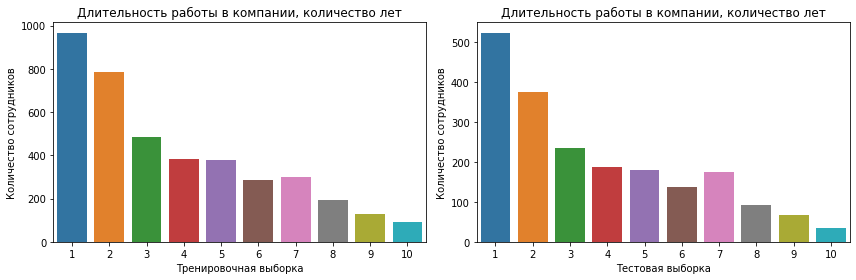

In [103]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

sn.countplot(x='employment_years', data=train, ax=axes[0])
sn.countplot(x='employment_years', data=X_test, ax=axes[1])

axes[0].set_xlabel('Тренировочная выборка')
axes[0].set_ylabel('Количество сотрудников')
axes[0].set_title('Длительность работы в компании, количество лет')

axes[1].set_xlabel('Тестовая выборка')
axes[1].set_ylabel('Количество сотрудников')
axes[1].set_title('Длительность работы в компании, количество лет')

plt.tight_layout()

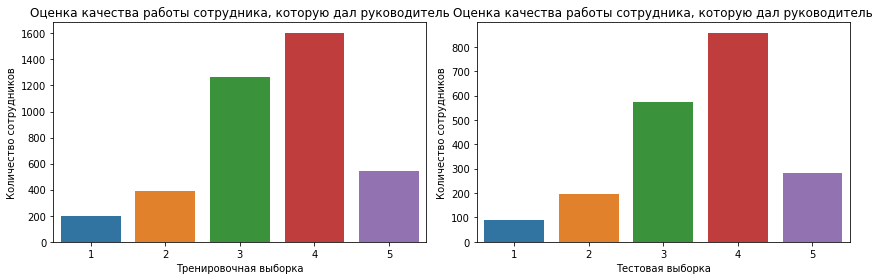

In [105]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

sn.countplot(x='supervisor_evaluation', data=train, ax=axes[0])
sn.countplot(x='supervisor_evaluation', data=X_test, ax=axes[1])

axes[0].set_xlabel('Тренировочная выборка')
axes[0].set_ylabel('Количество сотрудников')
axes[0].set_title('Оценка качества работы сотрудника, которую дал руководитель')

axes[1].set_xlabel('Тестовая выборка')
axes[1].set_ylabel('Количество сотрудников')
axes[1].set_title('Оценка качества работы сотрудника, которую дал руководитель')

plt.tight_layout()

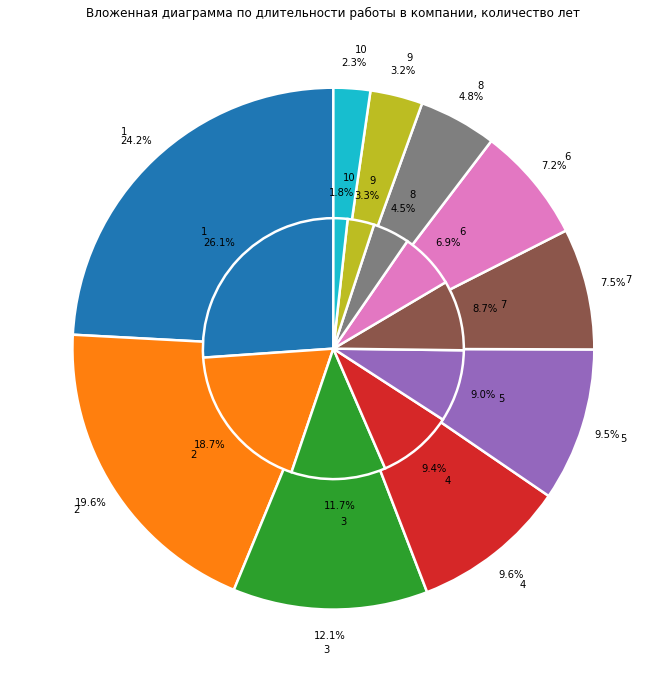

Внешняя - данные по тренировочной выборке
Внутренняя - данные по тестовой выборке


In [27]:
# Подсчитываем уникальные значения в каждой категории
category1_counts = train['employment_years'].value_counts()
category2_counts = X_test['employment_years'].value_counts()

fig, ax = plt.subplots(figsize = (30, 12))

# Внешняя диаграмма
ax.pie(category1_counts, 
       labels=category1_counts.index, 
       autopct='%1.1f%%', 
       startangle=90,
       wedgeprops={'lw':2.5, 'ls':'-','edgecolor':"w"},
       labeldistance= 1.15,
      pctdistance = 1.1)

# Сохраняем пропорции
plt.gca().set_aspect('equal')

# Вложенная диаграмма
ax.pie(category2_counts, 
       labels=category2_counts.index, 
       autopct='%1.1f%%', 
       startangle=90, 
       radius=0.5, 
       wedgeprops={'lw':2.5, 'ls':'-','edgecolor':"w"},
       labeldistance= 1.32,
       pctdistance = 1.2)

plt.title('Вложенная диаграмма по длительности работы в компании, количество лет')
plt.show()

print('Внешняя - данные по тренировочной выборке')
print('Внутренняя - данные по тестовой выборке')

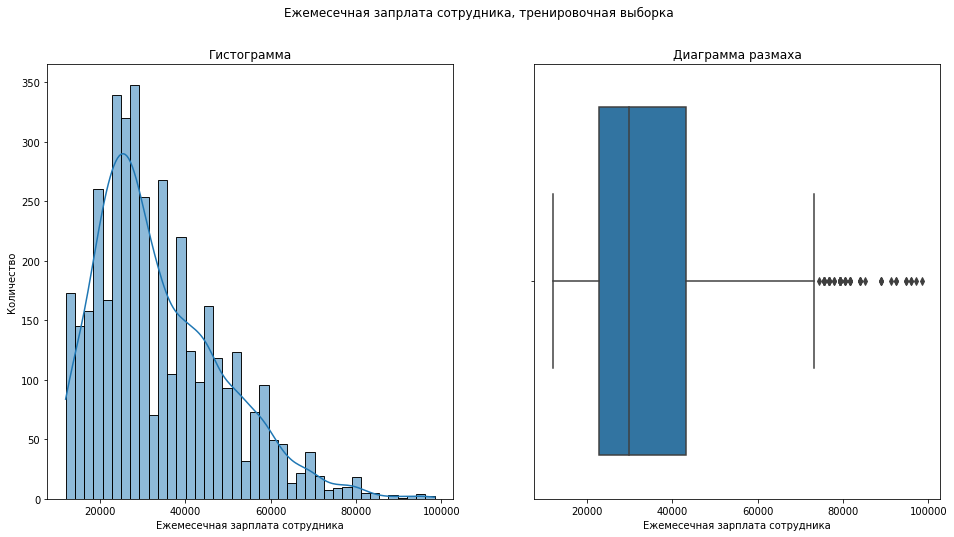

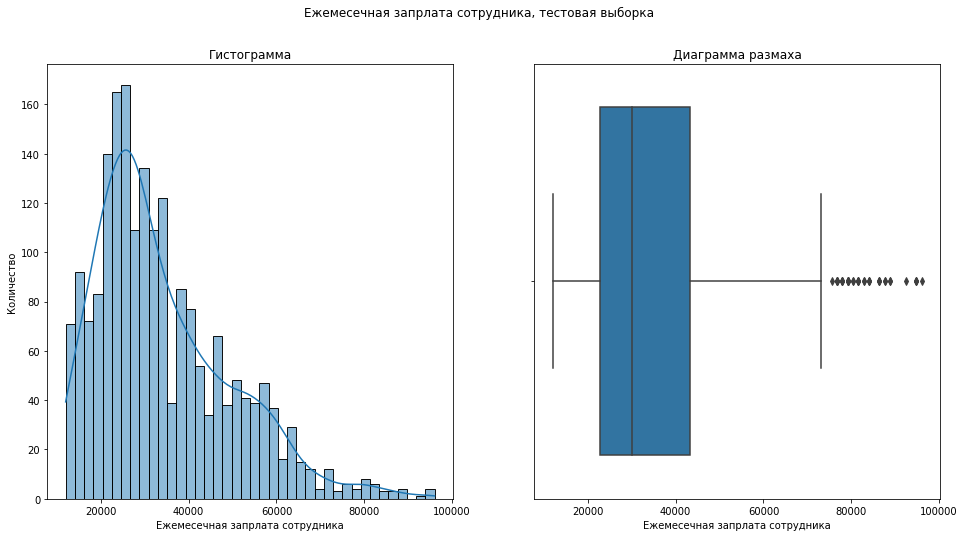

In [28]:
histplot_boxplot(train, 'salary', 
                 'Ежемесечная зарплата сотрудника', 
                 'Ежемесечная запрлата сотрудника, тренировочная выборка')

histplot_boxplot(X_test, 'salary', 
                 'Ежемесечная запрлата сотрудника',
                 'Ежемесечная запрлата сотрудника, тестовая выборка')

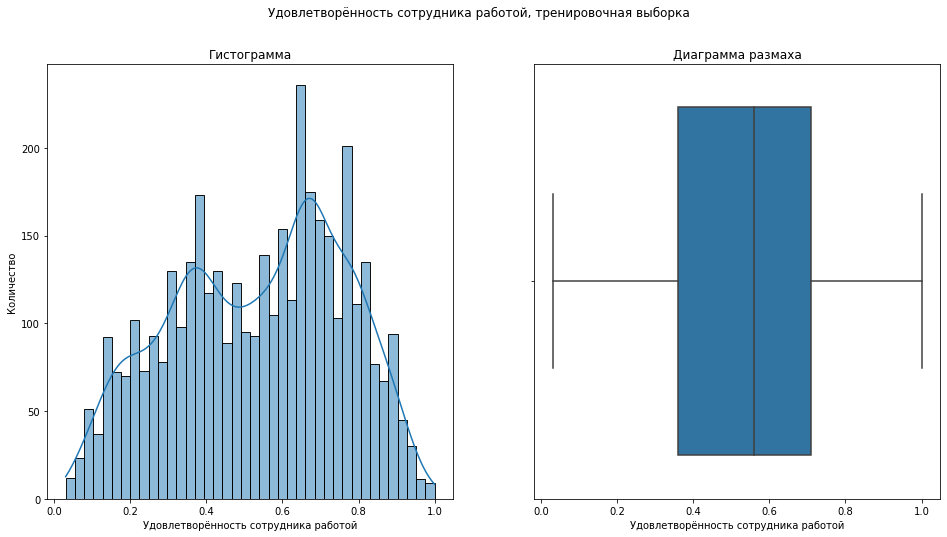

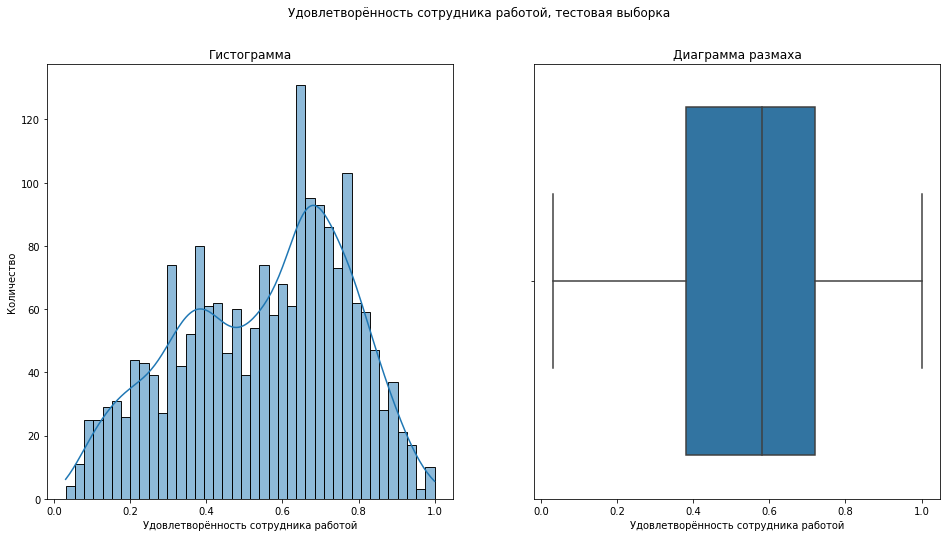

In [29]:
histplot_boxplot(train, 'job_satisfaction_rate', 
                 'Удовлетворённость сотрудника работой', 
                 'Удовлетворённость сотрудника работой, тренировочная выборка')

histplot_boxplot(y_test, 'job_satisfaction_rate', 
                 'Удовлетворённость сотрудника работой',
                 'Удовлетворённость сотрудника работой, тестовая выборка')

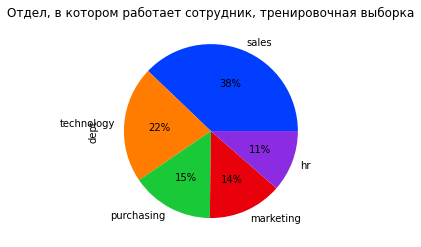

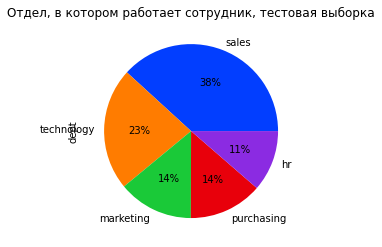

In [30]:
pie(train, 'dept', 'Отдел, в котором работает сотрудник, тренировочная выборка')
pie(X_test, 'dept', 'Отдел, в котором работает сотрудник, тестовая выборка')

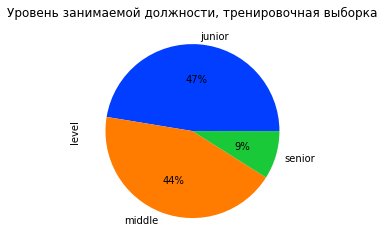

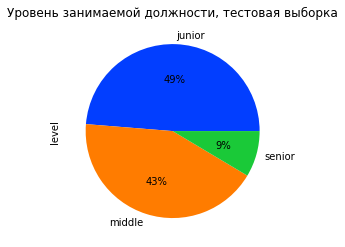

In [31]:
pie(train, 'level', 'Уровень занимаемой должности, тренировочная выборка')
pie(X_test, 'level', 'Уровень занимаемой должности, тестовая выборка')

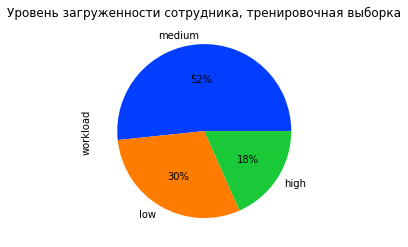

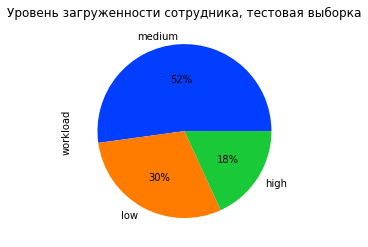

In [32]:
pie(train, 'workload', 'Уровень загруженности сотрудника, тренировочная выборка')
pie(X_test, 'workload', 'Уровень загруженности сотрудника, тестовая выборка')

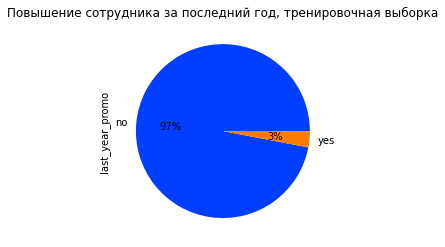

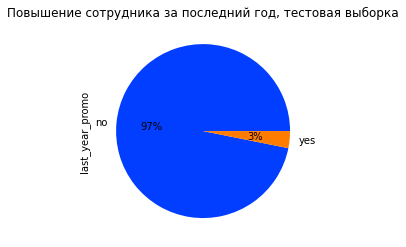

In [33]:
pie(train, 'last_year_promo', 'Повышение сотрудника за последний год, тренировочная выборка')
pie(X_test, 'last_year_promo', 'Повышение сотрудника за последний год, тестовая выборка')

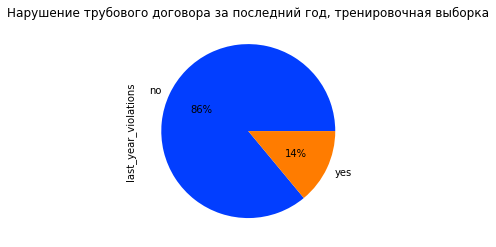

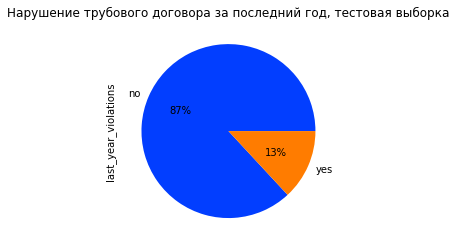

In [34]:
pie(train, 'last_year_violations', 'Нарушение трубового договора за последний год, тренировочная выборка')
pie(X_test, 'last_year_violations', 'Нарушение трубового договора за последний год, тестовая выборка')

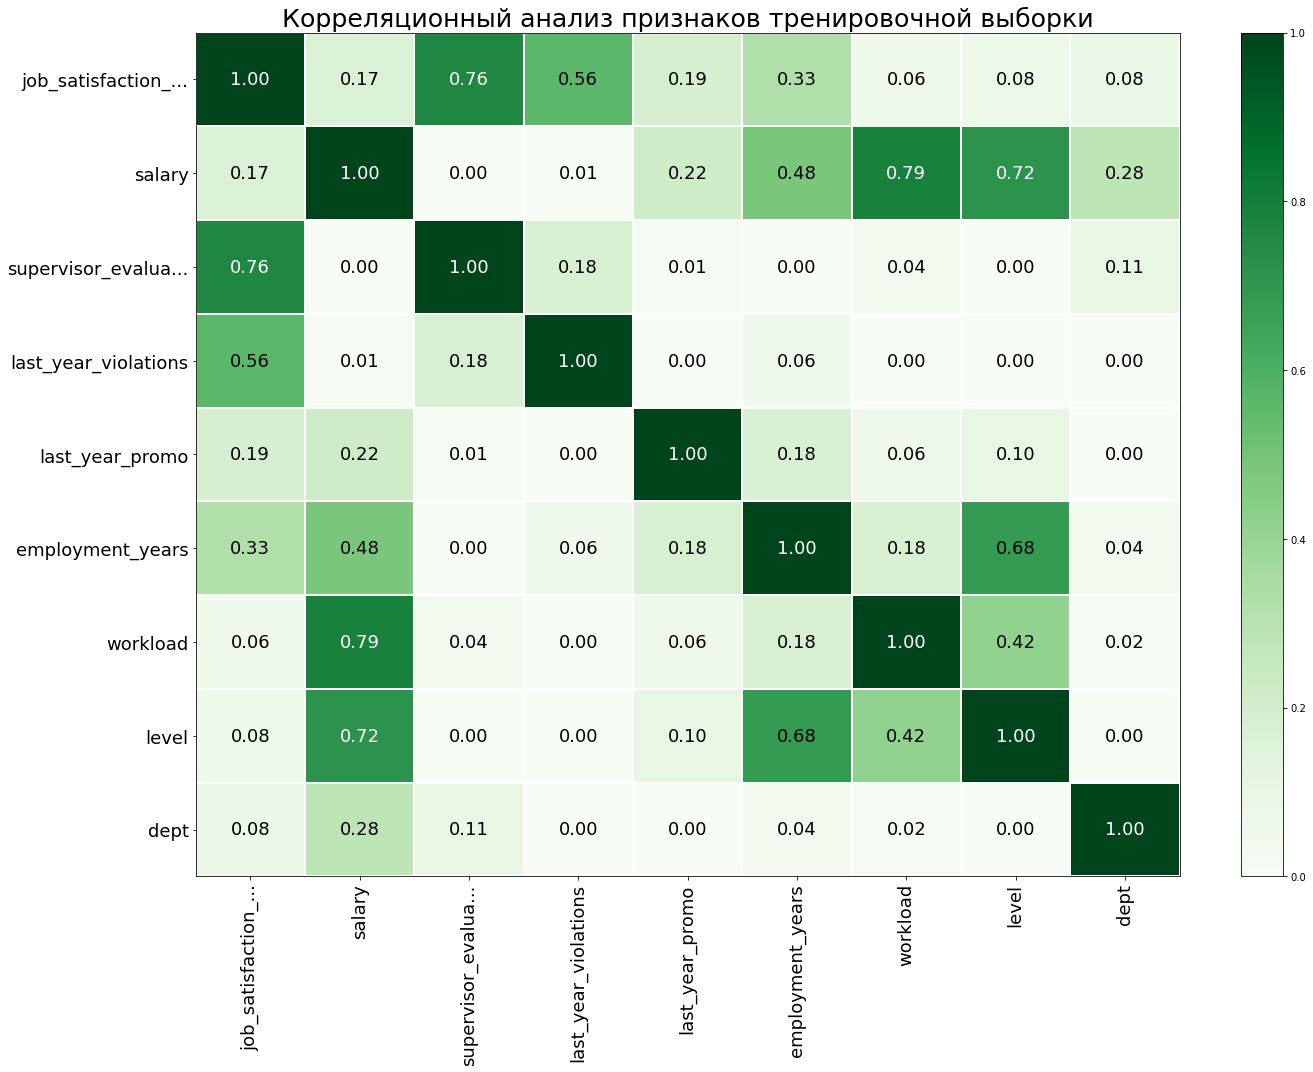

In [35]:
matrix_cor(train, 'Корреляционный анализ признаков тренировочной выборки')

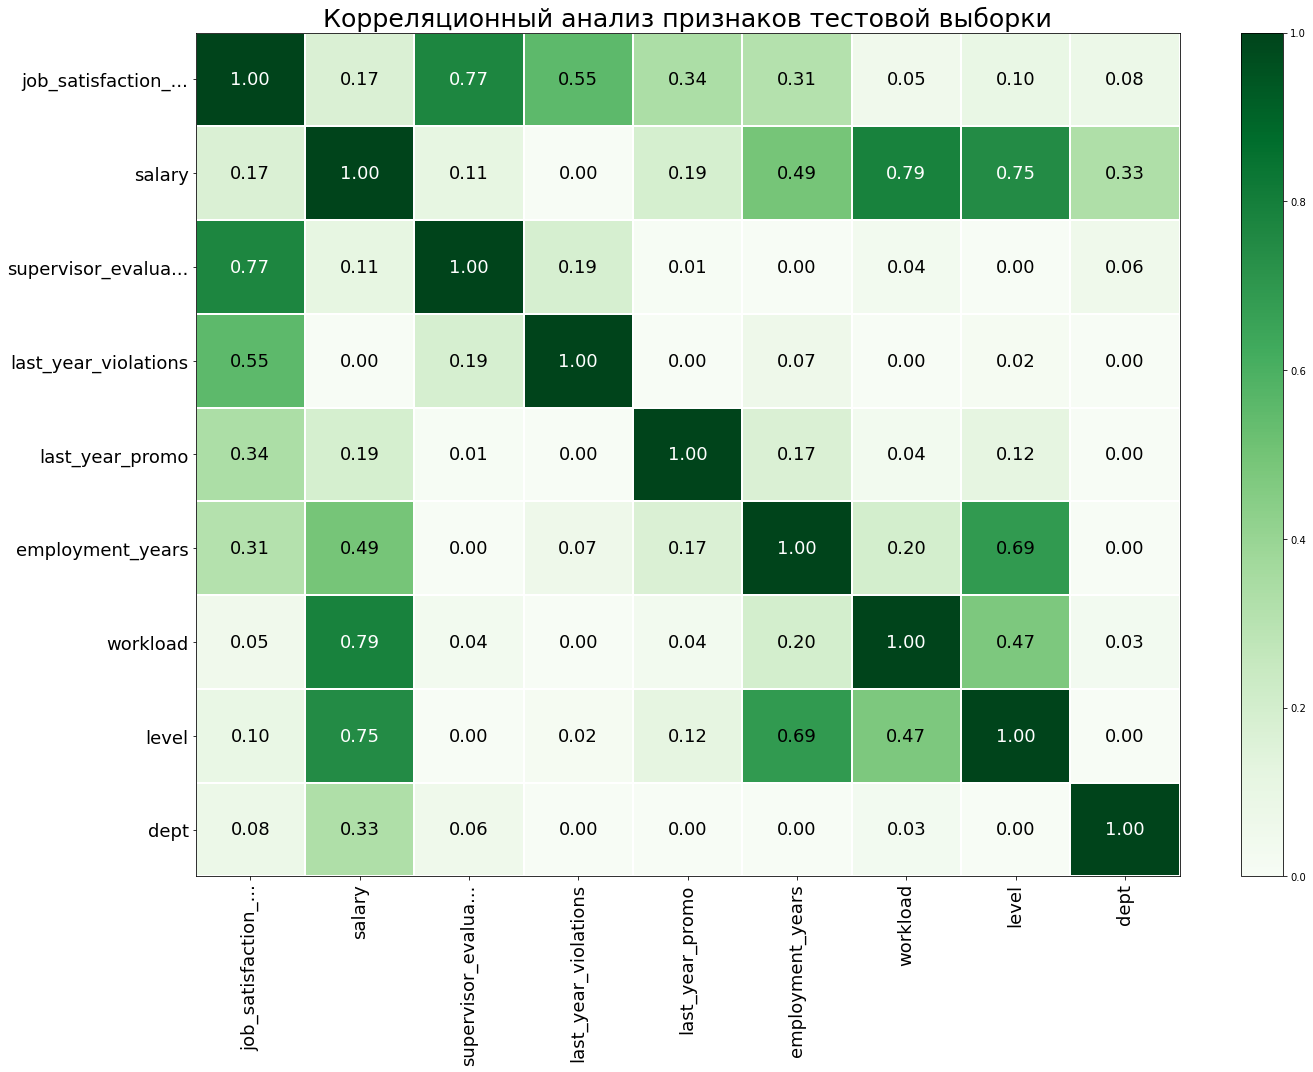

In [36]:
matrix_cor(X_test.join(y_test), 'Корреляционный анализ признаков тестовой выборки')

**Промежуточный вывод:**

*Оценка качества сотрудников:*

* Распределения данных в тренировочной и тестовой выборках имеют схожий тип (поэтому далее буду описывать гистограммы и диаграммы размаха общими словами для обоих выборок);
* Графики оценки качества работы сотрудников распределены нормально, но со смещением - так как средней оценкой является 4. Также на диаграмме размаха есть вывброс в виде 1, его мы не будем удалять, так как он не является аномалией, а вполне реалистичен, что какой-то сотрудник получил 1 за качество своей работы.

*Ежемесечная зп сотрудника:*

* Графики ЗП сотрудников распределены нормально со смещением влево, так как интервальный размах от 22800 до 43200 рублей, то есть основная часть сотрудников ЗП в данном диапазоне и также имеются выбросы на "ящике с усами" в виде больших ЗП. Скорее всего, они относятся к людям с высокой должностью и бОльшим опытом.

*Удовлетворенность сотрудника работой:*

* Удовлетворенность работой оценивается от 0 до 1. Среднее значение 0.53 (по тренировочной выборке), 0.55 (по тестовой выборке). Выбросов в данном сегменте нет, все значения реальны и не требуют обработки.

*Выводы по круговым диаграммам:*

* Для оценки длительности работы в компании выбрала вложенные диаграммы. Они наглядно показывают, что четверть сотрудников работает год, также около 20% 2 года, остальные сотрудники распределены в меньшей проподции. При этом в обоих выборках доли по годам практически одинаковы.
* Нарушение трудового договора встречается и составляет 14%.
* Джуны и миддлы занимают бОльшую часть, чем сеньоры.
* Распределение сотрудников по отделам в выборках практически идентичны, основная часть людей работает в отделе продаж.
* 52% сотруждников имеют среднюю загруженность, по 30% загруженны не сильно и оставшиеся 18% работают усиленно.
* За последний год повысели очень маленький процент людей.

*Корреляционный анализ:*

Проблема утечки тестовых и тренировочных данных не обнаружена на матрице корреляции - удалять признаки не требуется.

Следующие пары признаков тренировочных данных являются мультиколлениарными (их значения превышают 0.65):
- уровень загруженности и ежемесечная ЗП, 0.79 (это логично, скорее всего, кто выполняет больше работы получает надбавки и премии);
- уровень занимаемой должности и ЗП сотрудника, 0.72 (например, у мидллов и сеньеров зп больше, чем у джунов, прямая зависимость);
- уровень занимаемой должности и длительность работы в компании, 0.68 (со стажем сотрудника растет и доход).

Корреляция на тестовой выборке практически аналогична тренировочной

## 4. Подготовка данных

Для подготовки признаков будем использовать:
* MinMaxScaler/StandartScaler для стобцов employment_years, salary - стандартизация признаков;
* OrdinalEncoder для столбцов supervisor_evaluation, level, workload - преобразование категориальных признаков;
* OneHotEncoder для столбцов dept, last_year_promo, last_year_violations - преобразование признаков в бинарный формат.

Сгруппируем признаки, вручную разделим датафрейм на целевой признак и остальные, пропишем пайплайны.

In [37]:
ohe_columns = ['dept', 'last_year_promo',  'last_year_violations']
ord_columns = ['level', 'workload']
num_columns = ['supervisor_evaluation', 'employment_years', 'salary']

y = train['job_satisfaction_rate']
X = train.drop(['job_satisfaction_rate'], axis = 1)

In [38]:
# Добавляем OHE-кодирование в пайплайн

ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output =False)
        )
    ]
)

In [39]:
# Добавляем Ordinal-кодирование в пайплайн

ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',  
            OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'senior'],
                    ['low', 'medium', 'high']
                ], 
                handle_unknown='error'
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
) 

In [40]:
# Объединяем шаги подготовки

data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
) 

## 5. Обучение модели

In [41]:
# Создаём итоговый пайплайн для обучения модели

pipe_final= Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
])

In [42]:
# Перебираем гиперпараметры моделей

param_distributions = [
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': [None] + [i for i in range(2, 7)],
        'models__min_samples_split': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    },
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    },
    {
        'models': [Ridge(random_state = RANDOM_STATE, max_iter=10000, tol=1e-4)],
        'models__solver': ['saga', 'auto'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    }
] 


In [43]:
smape_scorer = make_scorer(smape_score, greater_is_better = False)

In [44]:
# Запускаем автоматический подбор с помощью GridSearchCV

grid_search = GridSearchCV(
    pipe_final, 
    param_distributions, 
    cv = 5,
    scoring=smape_scorer, 
    n_jobs=-1
)
grid_search.fit(X, y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('simpleImputer_ohe',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['dept',
                                                                          'last_year_promo',
                                                                          'last_year_violations']),
                                                                        ('ord',
                                                                         Pipeline(...
                         {'models': [LinearRegression()],
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(), RobustScaler(),
                                                'passthrough']},
                         {'models': [Ridge(max_iter=10000, random_state=42)],
                          'models__solver': ['saga', 'auto'],
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(), RobustScaler(),
                                                'passthrough']}],
             scoring=make_scorer(smape_score, greater_is_better=False, response_method='predict'))

In [45]:
print('Лучшая модель и её параметры:\n\n', grid_search.best_estimator_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                            

In [46]:
print(f'Метрика лучшей модели на кросс-валидации: {-grid_search.best_score_}')

Метрика лучшей модели на кросс-валидации: 14.57123737614124


In [47]:
y_test = y_test.sort_index()
X_test = X_test.sort_index()

In [48]:
y_predict = grid_search.predict(X_test)

In [49]:
smape_score(np.array(y_test['job_satisfaction_rate']), y_predict)

13.983212893979857

## 6. Оформление выводов

В данной задаче была проведена загрузка и предобработка данных, а также исследованны графики и диаграммы по данным и рассмотрен корреляционный анализ. Также были сформированны пайплайны для обучения моделей. 

Критерий успеха для лучшей модели должен не превышать 15. Значение на тестовой выборке равно 13.98, что не превышает необходимого значения. Лучше моделью стала DecisionTreeRegressor(min_samples_split=6, random_state=42). Данная модель справилась лучше линейной регрессии, так как лучше справляется при нелинейной зависимости признаков, а, учитывая матрицу корреляции, можно сказать, что у нас признаков с такой зависимостью много.

# Задача 2

## 7. Загрузка данных

Для второй задачи все переменные будут с числом 2

У целевого признака тестовой выборки новый параметр:

* quit - увольнение сотрудника из компании

In [50]:
train_2 = pd.read_csv('/datasets/train_quit.csv')
X_test_2 = pd.read_csv('/datasets/test_features.csv')
y_test_2 = pd.read_csv('/datasets/test_target_quit.csv')

In [51]:
df_info(train_2)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
2349,159757,marketing,middle,medium,4,no,no,4,37200,no
2448,815430,technology,middle,medium,3,no,no,4,45600,no
2157,749381,sales,middle,medium,6,no,no,4,33600,no
847,775797,purchasing,middle,high,7,no,no,2,52800,no
2404,813849,hr,junior,medium,1,no,no,4,30000,no
3443,871965,purchasing,middle,low,6,no,no,3,24000,no
880,404416,sales,junior,low,4,no,no,5,19200,no


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


None

------------------------------------------
Количество явных дубликатов:  0
------------------------------------------
Количество пропусков:
id                       0
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
quit                     0
dtype: int64


In [52]:
df_info(X_test_2)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
246,883192,hr,sinior,medium,1,yes,no,4,48000
755,313659,sales,junior,low,4,no,yes,3,14400
189,788782,sales,junior,medium,2,no,no,2,24000
339,185839,hr,junior,medium,3,no,no,4,30000
1878,344084,sales,junior,high,1,no,no,3,31200
716,814040,sales,middle,low,3,no,no,3,19200
1208,784037,sales,junior,medium,1,no,no,3,25200


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


None

------------------------------------------
Количество явных дубликатов:  0
------------------------------------------
Количество пропусков:
id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64


In [53]:
df_info(y_test_2)

,id,quit
1861,161234,no
157,374265,yes
1898,219716,no
1564,208827,no
1178,162854,yes
1721,722930,no
1769,917620,no


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


None

------------------------------------------
Количество явных дубликатов:  0
------------------------------------------
Количество пропусков:
id      0
quit    0
dtype: int64


**Промежуточный вывод:**

* Все названия столбцов в df записаны в "змеином_регистре";
* Типы данных заданы логично;
* Явные дубликаты не выявлены;
* Пропуски есть, далее обработаем их.

## 8. Предобработка данных

Проводим предобработку данных аналогично первой задаче

In [54]:
dublicates(train_2)

dept ['sales' 'purchasing' 'marketing' 'technology' 'hr']
level ['middle' 'junior' 'sinior']
workload ['high' 'medium' 'low']
last_year_promo ['no' 'yes']
last_year_violations ['no' 'yes']
quit ['no' 'yes']


In [55]:
dublicates(X_test_2)

dept ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
level ['junior' 'middle' 'sinior' nan]
workload ['medium' 'low' 'high' ' ']
last_year_promo ['no' 'yes']
last_year_violations ['no' 'yes']


In [56]:
train_2.loc[train_2['level'] == 'sinior', 'level'] = 'senior'
X_test_2.loc[X_test_2['level'] == 'sinior', 'level'] = 'senior'

In [57]:
display(X_test_2.loc[X_test_2['dept'] == ' '].T)
display(X_test_2.loc[X_test_2['workload'] == ' '].T)

,1699
id,822186
dept,
level,middle
workload,medium
employment_years,3
last_year_promo,no
last_year_violations,no
supervisor_evaluation,4
salary,38400


,15
id,590867
dept,marketing
level,junior
workload,
employment_years,4
last_year_promo,no
last_year_violations,no
supervisor_evaluation,4
salary,28800


In [58]:
X_test_2.loc[X_test_2['dept'] == ' ', 'dept'] = np.nan
X_test_2.loc[X_test_2['workload'] == ' ', 'workload'] = np.nan

In [59]:
print('train:')
display(missing(train_2))
print('X_test:')
display(missing(X_test_2))
print('y_test:')
display(missing(y_test_2))

train:


,missing_values,%
id,0,0.0
dept,0,0.0
level,0,0.0
workload,0,0.0
employment_years,0,0.0
last_year_promo,0,0.0
last_year_violations,0,0.0
supervisor_evaluation,0,0.0
salary,0,0.0
quit,0,0.0


X_test:


,missing_values,%
dept,3,0.0
level,1,0.0
workload,1,0.0
id,0,0.0
employment_years,0,0.0
last_year_promo,0,0.0
last_year_violations,0,0.0
supervisor_evaluation,0,0.0
salary,0,0.0


y_test:


,missing_values,%
id,0,0.0
quit,0,0.0


In [60]:
train_2.set_index('id', inplace=True)
X_test_2.set_index('id', inplace=True)
y_test_2.set_index('id', inplace=True)

## 9. Исследовательский анализ

In [61]:
print('Тренировочная выборка:')
display(train_2.describe().T)
print()
print('Входные признаки тестовой выборки:')
display(X_test_2.describe().T)
print()
print('Целевой признак тестовой выборки:')
display(y_test_2.describe().T)

Тренировочная выборка:


,count,mean,std,min,25%,50%,75%,max
employment_years,4000.0,3.70150,2.541852,1.0,2.0,3.0,6.0,10.0
supervisor_evaluation,4000.0,3.47475,1.004049,1.0,3.0,4.0,4.0,5.0
salary,4000.0,33805.80000,15152.415163,12000.0,22800.0,30000.0,43200.0,96000.0



Входные признаки тестовой выборки:


,count,mean,std,min,25%,50%,75%,max
employment_years,2000.0,3.6665,2.537222,1.0,1.0,3.0,6.0,10.0
supervisor_evaluation,2000.0,3.5265,0.996892,1.0,3.0,4.0,4.0,5.0
salary,2000.0,34066.8000,15398.436729,12000.0,22800.0,30000.0,43200.0,96000.0



Целевой признак тестовой выборки:


,count,unique,top,freq
quit,2000,2,no,1436


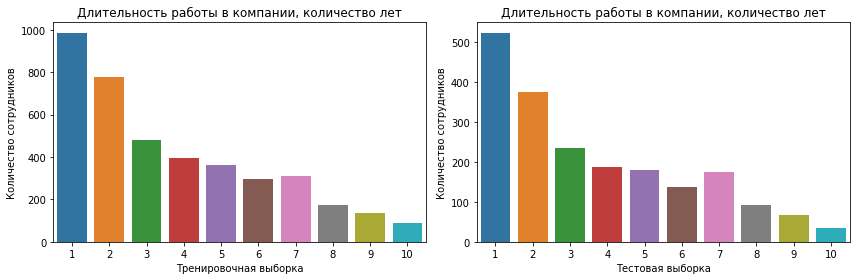

In [106]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

sn.countplot(x='employment_years', data=train_2, ax=axes[0])
sn.countplot(x='employment_years', data=X_test_2, ax=axes[1])

axes[0].set_xlabel('Тренировочная выборка')
axes[0].set_ylabel('Количество сотрудников')
axes[0].set_title('Длительность работы в компании, количество лет')

axes[1].set_xlabel('Тестовая выборка')
axes[1].set_ylabel('Количество сотрудников')
axes[1].set_title('Длительность работы в компании, количество лет')

plt.tight_layout()

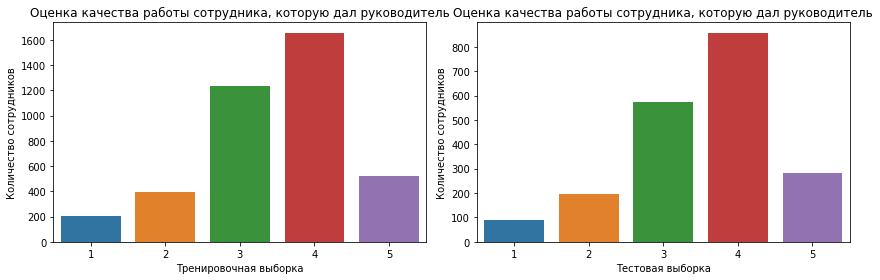

In [107]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

sn.countplot(x='supervisor_evaluation', data=train_2, ax=axes[0])
sn.countplot(x='supervisor_evaluation', data=X_test_2, ax=axes[1])

axes[0].set_xlabel('Тренировочная выборка')
axes[0].set_ylabel('Количество сотрудников')
axes[0].set_title('Оценка качества работы сотрудника, которую дал руководитель')

axes[1].set_xlabel('Тестовая выборка')
axes[1].set_ylabel('Количество сотрудников')
axes[1].set_title('Оценка качества работы сотрудника, которую дал руководитель')

plt.tight_layout()

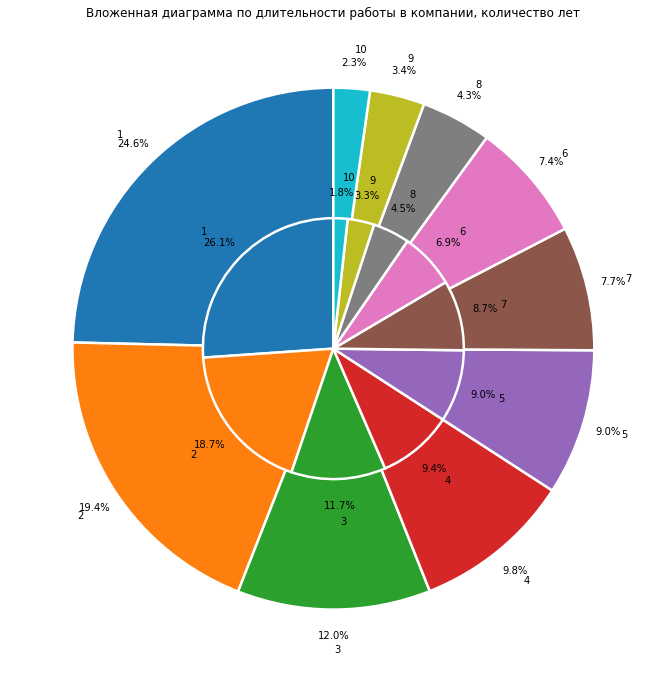

Внешняя - данные по тренировочной выборке
Внутренняя - данные по тестовой выборке


In [64]:
# Подсчитываем уникальные значения в каждой категории
category1_counts = train_2['employment_years'].value_counts()
category2_counts = X_test_2['employment_years'].value_counts()

fig, ax = plt.subplots(figsize = (30, 12))

# Внешняя диаграмма
ax.pie(category1_counts, 
       labels=category1_counts.index, 
       autopct='%1.1f%%', 
       startangle=90,
       wedgeprops={'lw':2.5, 'ls':'-','edgecolor':"w"},
       labeldistance= 1.15,
      pctdistance = 1.1)

# Сохраняем пропорции
plt.gca().set_aspect('equal')

# Вложенная диаграмма
ax.pie(category2_counts, 
       labels=category2_counts.index, 
       autopct='%1.1f%%', 
       startangle=90, 
       radius=0.5, 
       wedgeprops={'lw':2.5, 'ls':'-','edgecolor':"w"},
       labeldistance= 1.32,
       pctdistance = 1.2)

plt.title('Вложенная диаграмма по длительности работы в компании, количество лет')
plt.show()

print('Внешняя - данные по тренировочной выборке')
print('Внутренняя - данные по тестовой выборке')

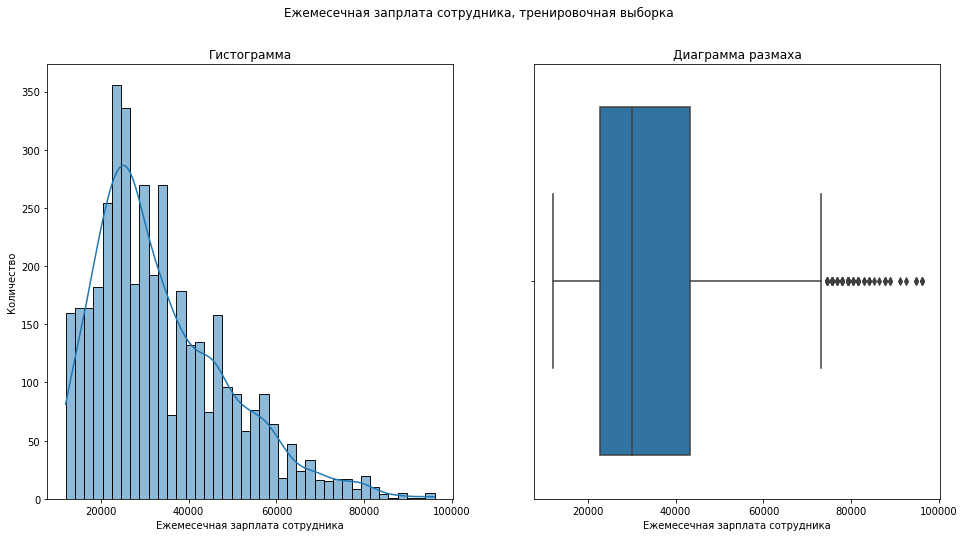

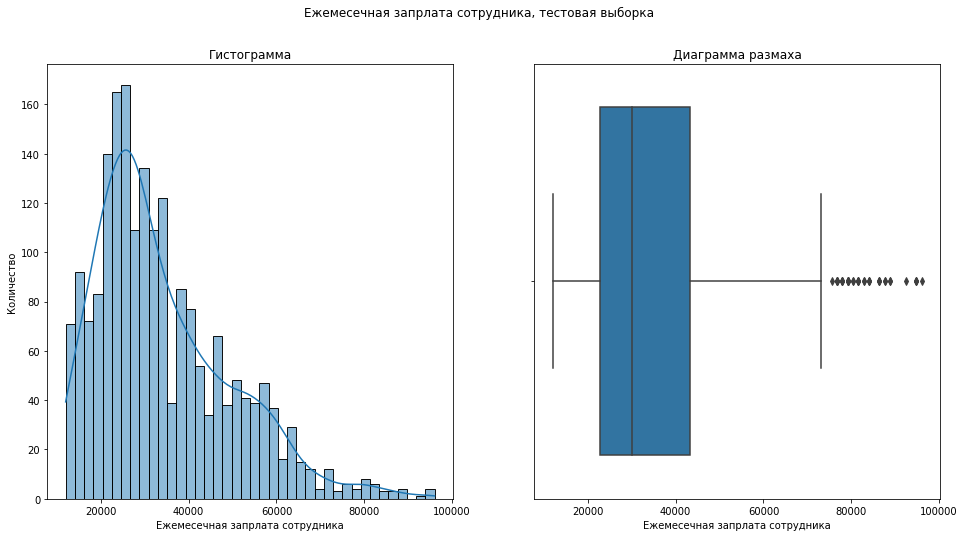

In [65]:
histplot_boxplot(train_2, 'salary', 
                 'Ежемесечная зарплата сотрудника', 
                 'Ежемесечная запрлата сотрудника, тренировочная выборка')

histplot_boxplot(X_test_2, 'salary', 
                 'Ежемесечная запрлата сотрудника',
                 'Ежемесечная запрлата сотрудника, тестовая выборка')

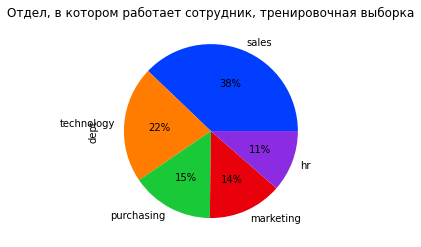

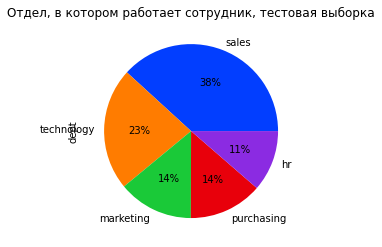

In [66]:
pie(train, 'dept', 'Отдел, в котором работает сотрудник, тренировочная выборка')
pie(X_test, 'dept', 'Отдел, в котором работает сотрудник, тестовая выборка')

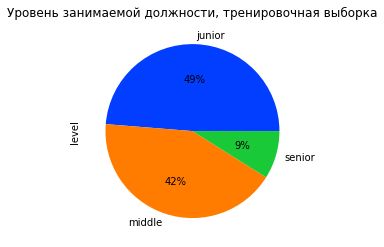

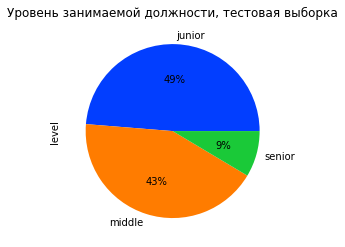

In [67]:
pie(train_2, 'level', 'Уровень занимаемой должности, тренировочная выборка')
pie(X_test_2, 'level', 'Уровень занимаемой должности, тестовая выборка')

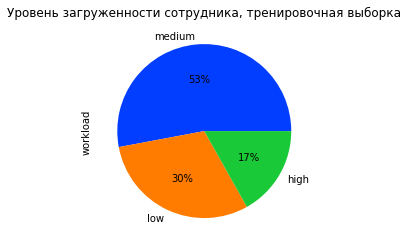

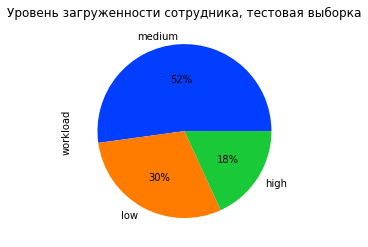

In [68]:
pie(train_2, 'workload', 'Уровень загруженности сотрудника, тренировочная выборка')
pie(X_test_2, 'workload', 'Уровень загруженности сотрудника, тестовая выборка')

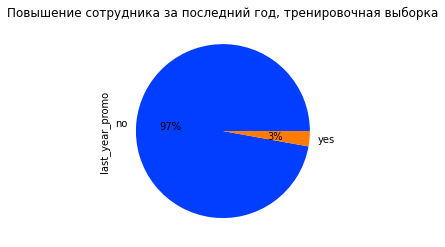

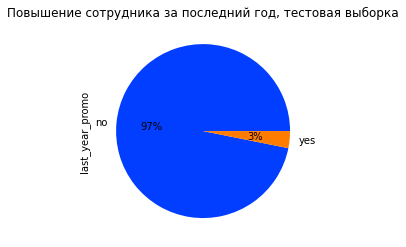

In [69]:
pie(train_2, 'last_year_promo', 'Повышение сотрудника за последний год, тренировочная выборка')
pie(X_test_2, 'last_year_promo', 'Повышение сотрудника за последний год, тестовая выборка')

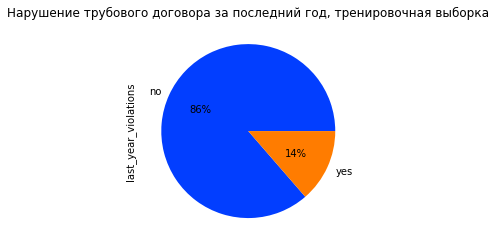

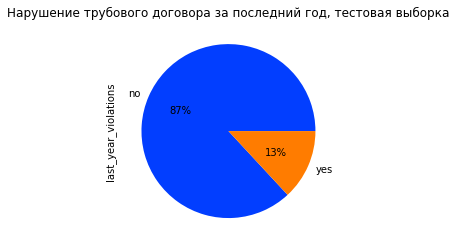

In [70]:
pie(train_2, 'last_year_violations', 'Нарушение трубового договора за последний год, тренировочная выборка')
pie(X_test_2, 'last_year_violations', 'Нарушение трубового договора за последний год, тестовая выборка')

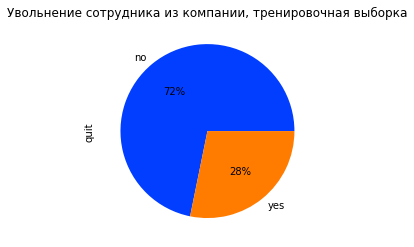

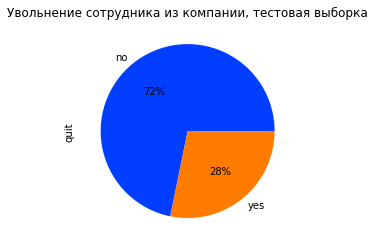

In [71]:
pie(train_2, 'quit', 'Увольнение сотрудника из компании, тренировочная выборка')
pie(y_test_2, 'quit', 'Увольнение сотрудника из компании, тестовая выборка')

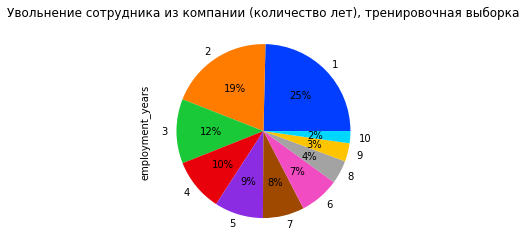

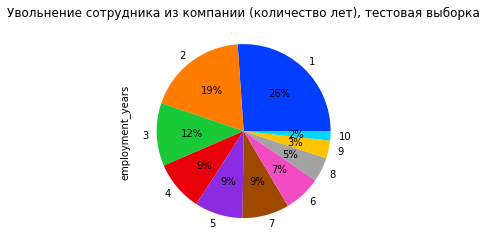

In [72]:
pie(train_2, 'employment_years', 'Увольнение сотрудника из компании (количество лет), тренировочная выборка')
pie(X_test_2, 'employment_years', 'Увольнение сотрудника из компании (количество лет), тестовая выборка')

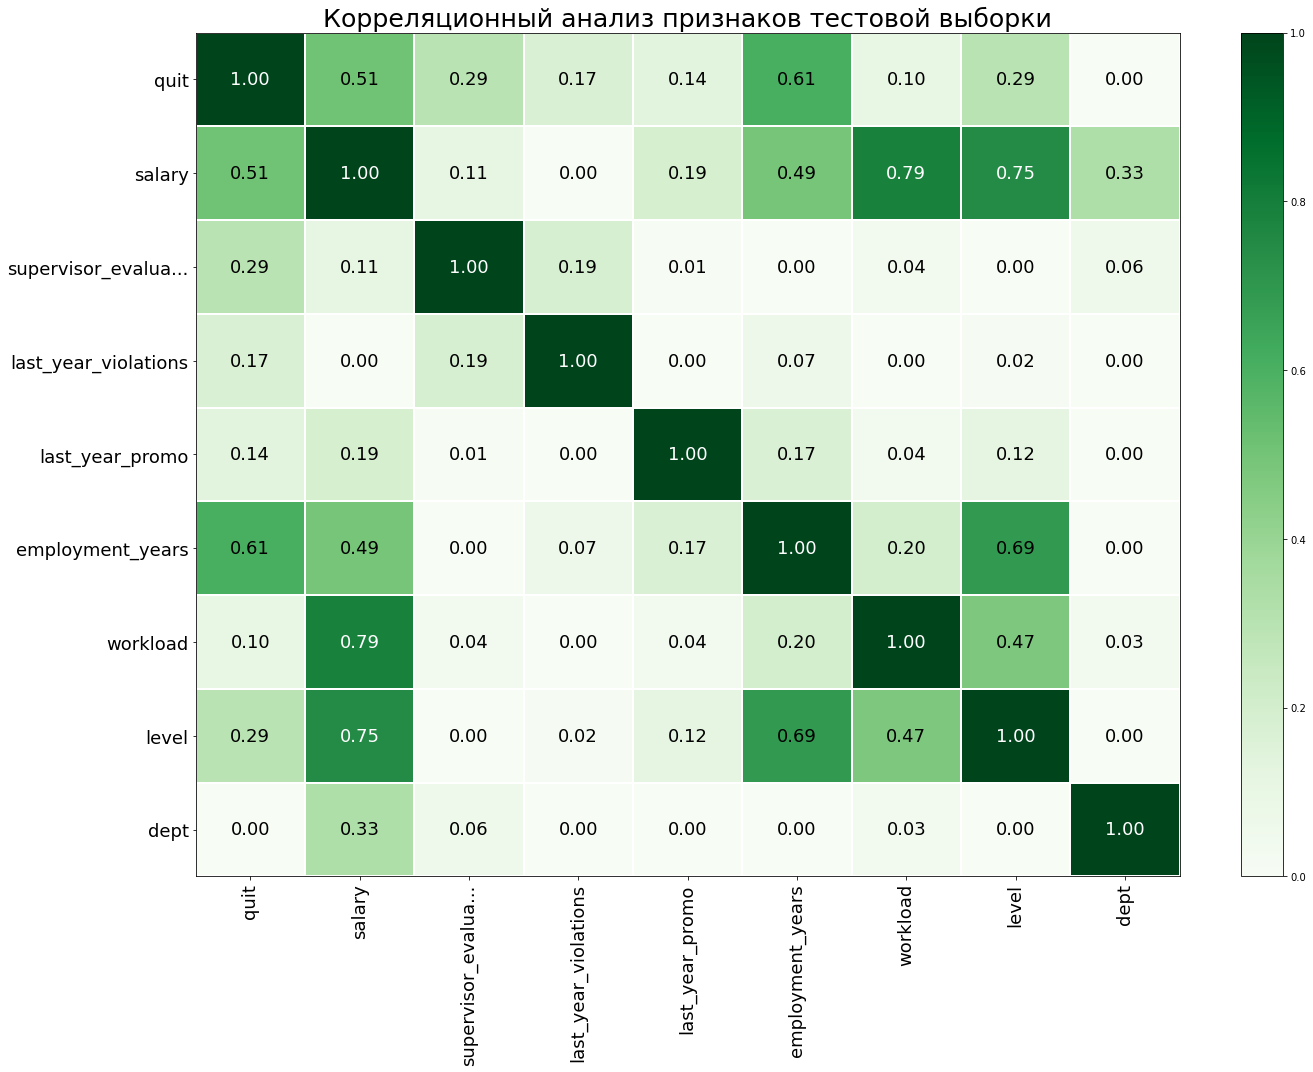

In [73]:
matrix_cor(X_test_2.join(y_test_2), 'Корреляционный анализ признаков тестовой выборки')

**Промежуточный вывод:**

* Распределение данных на тренировочной и тестовой выборках практически совпадает с задачей 1;

*"Увольнение сотрудника из компании":*

* Основная часть сотрудников (более 70%) не увольняется.
* Чаще сотрудники увольняются в первый и второй года их работы.

*Корреляционный анализ:*

Следующие пары признаков тренировочных данных являются мультиколлениарными (их значения превышают 0.65):

- уровень загруженности и ежемесечная ЗП, 0.79 (это логично, скорее всего, кто выполняет больше работы получает надбавки и премии);
- уровень занимаемой должности и ЗП сотрудника, 0.72 (например, у мидллов и сеньеров зп больше, чем у джунов, прямая зависимость);
- уровень занимаемой должности и длительность работы в компании, 0.69 (со стажем сотрудника растет и доход).
- увольнение сотрудников и длительность работы в компании, 0.61 (увольнение сотрудников напряямую связано с ростом их стажа в компании, сотрудники уходят в первые года).


### Портрет "уволившегося сотрудника"

Для создания "портрета уволившегося сотрудника" создадим новый датасет сотрудниками, которых постигло увольнение, и проведем по ним исследовательский анализ

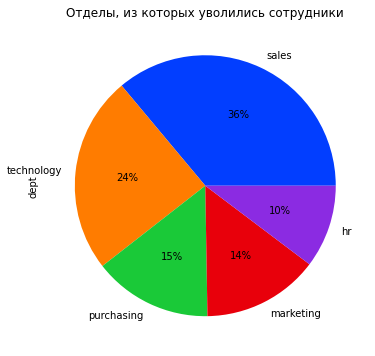

In [74]:
pie_2('dept', 'Отделы, из которых уволились сотрудники')

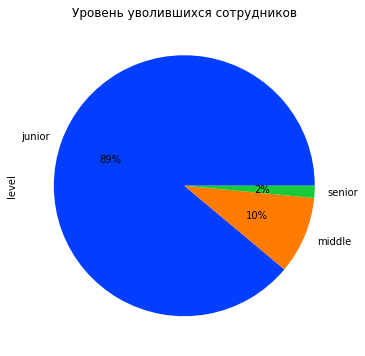

In [75]:
pie_2('level', 'Уровень уволившихся сотрудников')

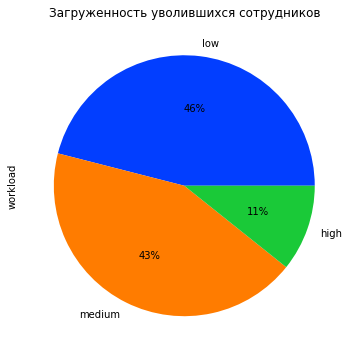

In [76]:
pie_2('workload', 'Загруженность уволившихся сотрудников')

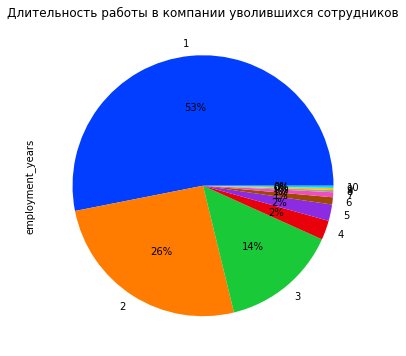

In [77]:
pie_2('employment_years', 'Длительность работы в компании уволившихся сотрудников')

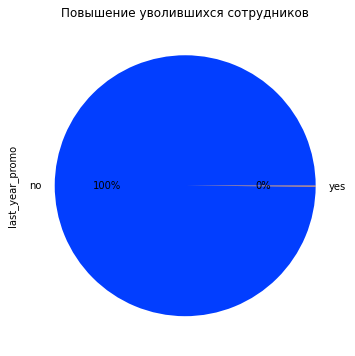

In [78]:
pie_2('last_year_promo', 'Повышение уволившихся сотрудников')

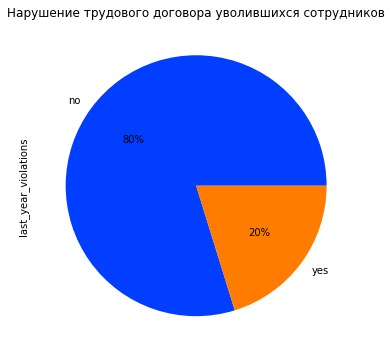

In [79]:
pie_2('last_year_violations', 'Нарушение трудового договора уволившихся сотрудников')

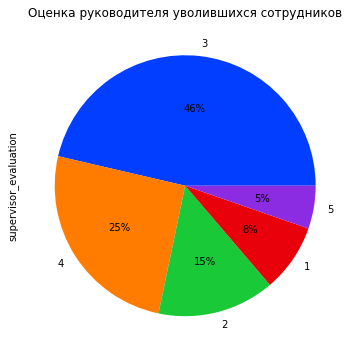

In [80]:
pie_2('supervisor_evaluation', 'Оценка руководителя уволившихся сотрудников')

In [81]:
# Сравним среднюю ЗП уволившихся и работающих сотрудников

no = train_2.loc[train_2['quit'] == 'no', 'salary'].mean()
yes = train_2.loc[train_2['quit'] == 'yes', 'salary'].mean()
print(f'Соотношение заработной платы уволившегося сотрудника к оставшемуся {round((no/yes - 1)*100, 2)} %')

Соотношение заработной платы уволившегося сотрудника к оставшемуся 57.85 %


**Визуализируем и сравним распределения признака "уровень удовлетворённости сотрудника работой в компании" (job_satisfaction_rate)  для ушедших и оставшихся сотрудников**

In [82]:
y_test_2 = y_test_2.sort_index()
X_test_2 = X_test_2.sort_index()

In [83]:
new_test = X_test_2
new_test['job_satisfaction_rate'] = y_test['job_satisfaction_rate']
new_test['quit'] = y_test_2['quit']

In [84]:
new_test.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate,quit
id,,,,,,,,,,
100298,hr,junior,low,2,no,no,4,19200,0.80,no
100480,marketing,junior,low,4,no,no,4,16800,0.84,no
100503,purchasing,middle,high,5,no,no,4,55200,0.79,no
100610,sales,middle,medium,5,no,no,4,43200,0.75,no
100692,sales,middle,high,6,no,no,4,48000,0.69,no


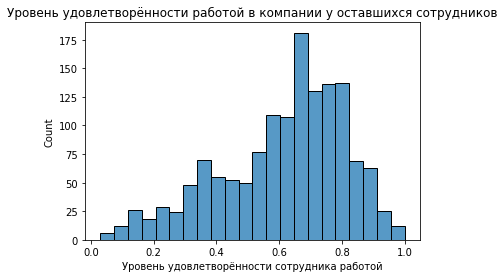

In [85]:
sn.histplot(data = new_test.loc[new_test['quit']=='no'], 
            x='job_satisfaction_rate')
plt.xlabel('Уровень удовлетворённости сотрудника работой')
plt.title('Уровень удовлетворённости работой в компании у оставшихся сотрудников')
plt.show()

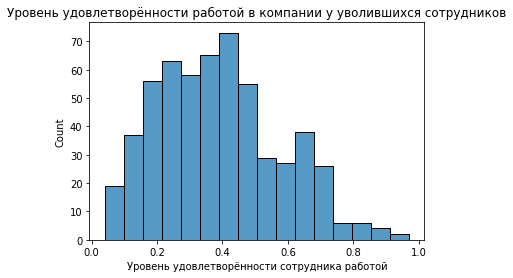

In [86]:
sn.histplot(data = new_test.loc[new_test['quit']=='yes'], 
            x='job_satisfaction_rate')
plt.xlabel('Уровень удовлетворённости сотрудника работой')
plt.title('Уровень удовлетворённости работой в компании у уволившихся сотрудников')
plt.show()

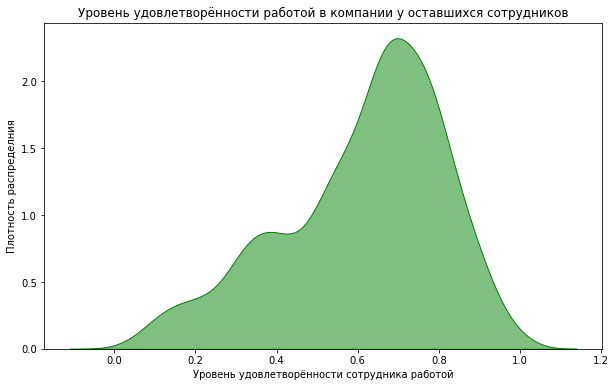

In [87]:
plt.figure(figsize=(10, 6))
sn.kdeplot(data=new_test.loc[new_test['quit']=='no'],
           x='job_satisfaction_rate', 
            fill=True, 
            color='green', 
            alpha=0.5)
plt.title('Уровень удовлетворённости работой в компании у оставшихся сотрудников')
plt.xlabel('Уровень удовлетворённости сотрудника работой')
plt.ylabel('Плотность распределния')
plt.show()

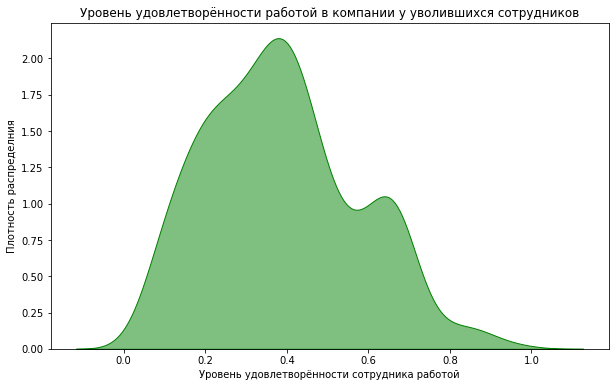

In [88]:
plt.figure(figsize=(10, 6))
sn.kdeplot(data=new_test.loc[new_test['quit']=='yes'],
           x='job_satisfaction_rate', 
            fill=True, 
            color='green', 
            alpha=0.5)
plt.title('Уровень удовлетворённости работой в компании у уволившихся сотрудников')
plt.xlabel('Уровень удовлетворённости сотрудника работой')
plt.ylabel('Плотность распределния')
plt.show()

**Промежуточный вывод:**

*Отделы, из которых уволились сотрудники:*

* Основная часть сотрудников ушла из отдела продаж (36%) и четверть (24%) из отдела технологий.

*Уровень уволившихся сотрудников*:

* Уходят из компании в основном только джуны (89%).

*Загруженность уволившихся сотрудников:*

* Сотрудники, которые уволились, либо не сильно были загружены (46%), либо имели среднюю степень загруженности (43%).

*Длительность работы в компании уволившихся сотрудников:*

* Из компании уходят после 1-3 лет работы.

*Повышение уволившихся сотрудников:*

* Сотрудники, которые в результате ушли, не получили повышения.

*Нарушение трудового договора уволившихся сотрудников:*

* Только у 20% уволившихся было нарушение трудового договора.

*Оценка работы от руководителя*

* Основная часть ушедших справлялась на 3 и 4  по оценке руководителя

*Сравнение ЗП:*

* Средняя зааботная плата неуволившегося сотрудника на 58% больше уволившегося

*Сравнение уровня удовлетворенности работой у уволившегося сотрудника и оставшегося:*

* Графиу оставшихся сотрудников смещен вправо, к соблее высоким оценкам, а график ушедших смещен левее - к низким оценкам. Анализируя данные графики, можно сказать, что уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник, ведь если у уволившихся сотрудниках в большинстве случаев он меньше 0.5, то у оставшихся - больше 0.6

## 10. Добавление нового входного признака

В данном этапе добавим новый столбец к датафреймам

In [89]:
train_2['job_satisfaction_rate'] = grid_search.predict(train_2.drop(['quit'], axis = 1))
X_test_2['job_satisfaction_rate'] = grid_search.predict(X_test_2)

In [90]:
X_test_2.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate,quit
id,,,,,,,,,,
100298,hr,junior,low,2,no,no,4,19200,0.820000,no
100480,marketing,junior,low,4,no,no,4,16800,0.852000,no
100503,purchasing,middle,high,5,no,no,4,55200,0.746667,no
100610,sales,middle,medium,5,no,no,4,43200,0.813333,no
100692,sales,middle,high,6,no,no,4,48000,0.697500,no


## 11. Подготовка данных

Часть пайплайном уже были прописаны в первой задаче, поэтому воспользуемся ими

In [91]:
ohe_columns = ['dept', 'last_year_promo',  'last_year_violations']
ord_columns = ['level', 'workload']
num_columns = ['supervisor_evaluation', 'employment_years', 'salary', 'job_satisfaction_rate']

y = train_2['quit']
X = train_2.drop(['quit'], axis = 1)

In [92]:
le = LabelEncoder()

# обучаем и трансформируем тренировочную выборку 
y = le.fit_transform(y)

# трансформируем тестовую выборку
y_test_2 = le.transform(y_test_2)

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


## 12. Обучение моделей

In [93]:
pipe_final= Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LogisticRegression(random_state=RANDOM_STATE))
])

In [94]:
param_distributions = [
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(1, 20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler()]   
    },
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 11),
        'models__max_features': range(2, 11),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    },
    {
        'models': [SVC(random_state=RANDOM_STATE, probability= True)],
        'models__C': range(1, 10),
        'models__kernel': ['rbf', 'linear', 'sigmoid'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  

    },
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE, max_iter=1000, tol=1e-2)],
        'models__C': range(1, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    }
] 

In [95]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_distributions, 
    scoring='roc_auc', 
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X, y)

/opt/conda/lib/python3.9/site-packages/sklearn/compose/_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


RandomizedSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['dept',
                                                                                'last_year_promo',
                                                                                'last_year_violations']),
                                                                              ('ord',
                                                                               Pipeline...
                                         'models__C': range(1, 10),
                                         'models__kernel': ['rbf', 'linear',
                                                            'sigmoid'],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               RobustScaler(),
                                                               'passthrough']},
                                        {'models': [LogisticRegression(max_iter=1000,
                                                                       random_state=42,
                                                                       tol=0.01)],
                                         'models__C': range(1, 10),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               RobustScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='roc_auc')

In [96]:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                            

In [97]:
print(f'Метрика лучшей модели на кросс-валидации: {randomized_search.best_score_}')

Метрика лучшей модели на кросс-валидации: 0.9277326864303657


In [98]:
y_predict_proba = randomized_search.predict_proba(X_test_2)

In [99]:
roc_auc_score(y_test_2, y_predict_proba[:, 1])

0.9253979483988225

Значение метрики больше чем 0.91, значит всё прошло успешно

**Промежуточный вывод:**

В данном шаге была найдена и обучена лучшая модель по предсказанию увольнения сотрудника. Значение метрики на тестовой выборке составляет 0.93, что является успехом, ведь для неё необходимо значение >=0.91. Лучшей моделью стала SVC(C=3, probability=True, random_state=42). Данная модель справилась лучше остальных, так как лучше справляется при нелинейной зависимости признаков, а, учитывая матрицу корреляции, можно сказать, что у нас признаков с такой зависимостью много.

## 13. Оформление выводов

В данном проекте были перед нами стояли две задачи:

* построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика;
* построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

Перед построением модели были загруженны и обработанны данные, а также построены графики и диаграммы, по которым можно сделать следующие выводы:

* Графики оценки качества работы сотрудников распределены нормально, но со смещением - так как средней оценкой является 4. Также на диаграмме размаха есть вывброс в виде 1, его мы не будем удалять, так как он не является аномалией, а вполне реалистичен, что какой-то сотрудник получил 1 за качество своей работы.
* Графики ЗП сотрудников распределены нормально со смещением влево, так как интервальный размах от 22800 до 43200 рублей, то есть основная часть сотрудников ЗП в данном диапазоне и также имеются выбросы на "ящике с усами" в виде больших ЗП. Скорее всего, они относятся к людям с высокой должностью и бОльшим опытом.
* Удовлетворенность работой имеет среднее значение 0.53 (по тренировочной выборке), 0.55 (по тестовой выборке). Выбросов в данном сегменте нет, все значения реальны и не требуют обработки.
* Диаграммы длительности работы в компании наглядно показывают, что четверть сотрудников работает год, также около 20% 2 года, остальные сотрудники распределены в меньшей проподции. При этом в обоих выборках доли по годам практически одинаковы.
* Нарушение трудового договора встречается и составляет 14%.
* Джуны и миддлы занимают бОльшую часть, чем сеньоры.
* Распределение сотрудников по отделам в выборках практически идентичны, основная часть людей работает в отделе продаж.
* 52% сотруждников имеют среднюю загруженность, по 30% загруженны не сильно и оставшиеся 18% работают усиленно.
* За последний год повысели очень маленький процент людей.
* Основная часть сотрудников (более 70%) не увольняется.
* Чаще сотрудники увольняются в первый и второй года их работы.

Также был проведен корреляционный анализ:

Следующие пары признаков тренировочных данных являются мультиколлениарными (их значения превышают 0.65):
- уровень загруженности и ежемесечная ЗП, 0.79 (это логично, скорее всего, кто выполняет больше работы получает надбавки и премии);
- уровень занимаемой должности и ЗП сотрудника, 0.72 (например, у мидллов и сеньеров зп больше, чем у джунов, прямая зависимость);
- уровень занимаемой должности и длительность работы в компании, 0.68 (со стажем сотрудника растет и доход).

Вывод по **первой задаче**:

Критерий успеха для лучшей модели должен не превышать 15. Значение на тестовой выборке равно 13.98, что не превышает необходимого значения. Лучше моделью стала DecisionTreeRegressor(min_samples_split=6, random_state=42). Данная модель справилась лучше линейной регрессии, так как лучше справляется при нелинейной зависимости признаков, а, учитывая матрицу корреляции, можно сказать, что у нас признаков с такой зависимостью много.

Далее был создан портрет "уволившегося сотрудника". Он показал следующее:

* Основная часть сотрудников ушла из отдела продаж (36%) и четверть (24%) из отдела технологий.
* Уходят из компании в основном только джуны (89%).
* Сотрудники, которые уволились, либо не сильно были загружены (46%), либо имели среднюю степень загруженности (43%).
* Из компании уходят после 1-3 лет работы.
* Сотрудники, которые в результате ушли, не получили повышения.
* Только у 20% уволившихся было нарушение трудового договора.
* Основная часть ушедших справлялась на 3 и 4  по оценке руководителя.
* Средняя зааботная плата неуволившегося сотрудника на 58% больше уволившегося.

Вывод по **второй задаче**:

В данном шаге была найдена и обучена лучшая модель по предсказанию увольнения сотрудника. Значение метрики на тестовой выборке составляет 0.93, что является успехом, ведь для неё необходимо значение >=0.91. Лучшей моделью стала SVC(C=3, probability=True, random_state=42). Данная модель справилась лучше остальных, так как лучше справляется при нелинейной зависимости признаков, а, учитывая матрицу корреляции, можно сказать, что у нас признаков с такой зависимостью много.